In [1]:
from fit.datamodules.tomo_rec import MNISTTomoFourierTargetDataModule
from fit.utils import convert2FC, fft_interpolate, psfft, convert_to_dft, PSNR
from fit.utils.tomo_utils import get_proj_coords, get_img_coords

from matplotlib import pyplot as plt

import torch

import numpy as np

from skimage.transform import iradon

from fit.utils.utils import denormalize

# MNIST Tomo Fourier Target
Create a MNIST projection dataset with 15 angles and batch-size 4.

In [2]:
batch_size = 4
num_angles = 15
img_shape = 27
inner_circle = True

In [3]:
dm = MNISTTomoFourierTargetDataModule(root_dir='/home/tibuch/Data/mnist/', batch_size=batch_size, 
                                      num_angles=num_angles, inner_circle=inner_circle)
dm.setup()

In [4]:
mean, std = dm.mean, dm.std

In [5]:
train_dl = dm.train_dataloader()

In [6]:
for sino, img  in train_dl.dataset.ds:
    break

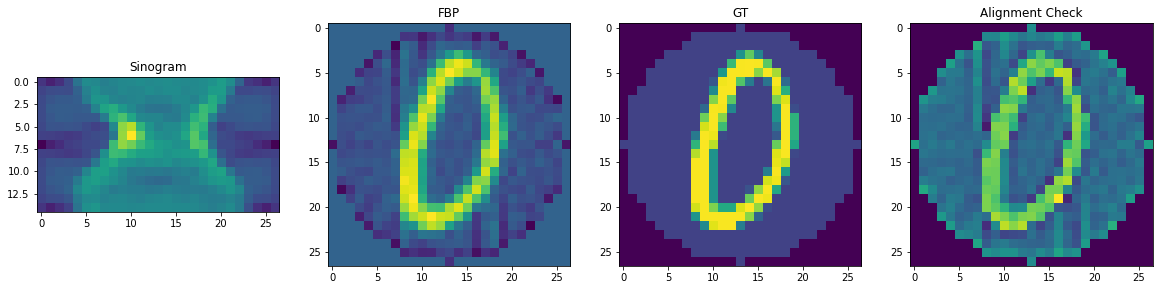

In [7]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(sino)
plt.title('Sinogram');
plt.subplot(1,4,2)
rec = iradon(sino.numpy().T, theta=np.rad2deg(-dm.gt_ds.get_ray_trafo().geometry.angles), circle=inner_circle,
                 output_size=img_shape).T
plt.imshow(rec)
plt.title('FBP');
plt.subplot(1,4,3)
plt.imshow(img)
plt.title('GT');
plt.subplot(1,4,4)
plt.imshow(img - rec)
plt.title('Alignment Check');

In [8]:
# x and y are normalized magnitude and angle of the Fourier coefficients
for x, y, y_real, (mag_min, mag_max) in train_dl:
    break

In [9]:
# We have to convert angle and magnitude back to Fourier coefficients
x_fc = convert2FC(x, mag_min, mag_max)
y_fc = convert2FC(y, mag_min, mag_max)

In [10]:
det_len = dm.gt_ds.get_ray_trafo().geometry.detector.shape[0]

In [11]:
# Computing the projection and target Fourier coefficient coordinates
srcx, srcy, src_flatten_order = get_proj_coords(angles=dm.gt_ds.get_ray_trafo().geometry.angles, 
                                                det_len=det_len)
dstx, dsty, dst_flatten_order, order = get_img_coords(img_shape=img_shape, 
                                                      det_len=det_len)
target_shape = order.shape
print('Fourier Space Shape:', target_shape)

Fourier Space Shape: (27, 14)


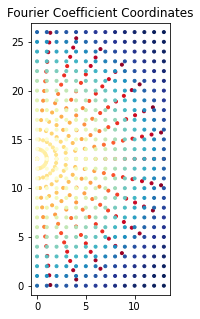

In [12]:
plt.figure(figsize=(2.5, 5))
plt.scatter(srcx, srcy, marker='.', label='Projection Coordinates', 
            c=np.arange(srcx.shape[0]), cmap='YlOrRd')
plt.scatter(dstx, dsty, marker='.', label='Target Coordinates', c=np.arange(dstx.shape[0]), 
            cmap='YlGnBu')

plt.axis('equal')
plt.title('Fourier Coefficient Coordinates');

In [13]:
bin_factor = 2
shells = (det_len//2+1)/bin_factor
num_sino_fcs = np.clip(num_angles*int(shells + 1), 1, x_fc.shape[1])
num_target_fcs = np.sum(order <= shells)

In [14]:
# Interpolate target Fourier coefficients based on projection Fourier coefficients --> Fourier Slice Theorem
i = 0
fc = x_fc[i][src_flatten_order]
fc[num_sino_fcs:] = 1
x_dft = fft_interpolate(srcx, srcy, dstx, dsty, fc, 
                        target_shape=target_shape, dst_flatten_order=dst_flatten_order)

In [15]:
y_fc_ = y_fc[i].numpy().flatten()[dst_flatten_order]
y_fc_[num_target_fcs:] = 1
y_fc_[dst_flatten_order] = y_fc_.flatten()

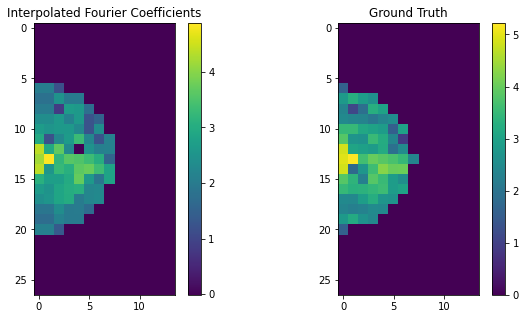

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.roll(np.log(np.abs(x_dft)), x_dft.shape[0]//2, 0))
plt.colorbar()
plt.title('Interpolated Fourier Coefficients');
plt.subplot(1,2,2)
plt.imshow(np.roll(np.log(np.abs(y_fc_.reshape(27, 14))), img_shape//2, 0))
plt.colorbar()
plt.title('Ground Truth');

In [17]:
print('#Inputs: {}/{}={:1.3f}'.format(num_sino_fcs, x_fc.shape[1], num_sino_fcs/x_fc.shape[1]))
print('#Targets: {}/{}={:1.3f}'.format(num_target_fcs, y_fc.shape[1], num_target_fcs/y_fc.shape[1]))

#Inputs: 120/210=0.571
#Targets: 82/378=0.217


In [18]:
mask = psfft(bin_factor, pixel_res=img_shape).numpy()

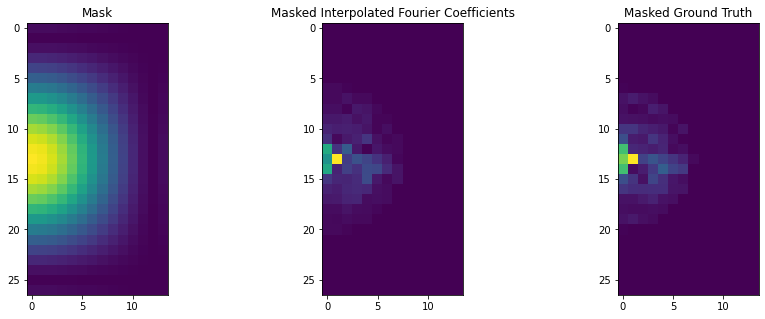

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(np.roll(np.abs(mask), img_shape//2, 0))
plt.title('Mask')
plt.subplot(1,3,2)
plt.imshow(np.roll(np.abs(x_dft*mask), img_shape//2, 0))
plt.title('Masked Interpolated Fourier Coefficients');
plt.subplot(1,3,3)
plt.imshow(np.roll(np.abs(y_fc_.reshape(img_shape, img_shape//2 + 1) * mask), img_shape//2, 0))
plt.title('Masked Ground Truth');

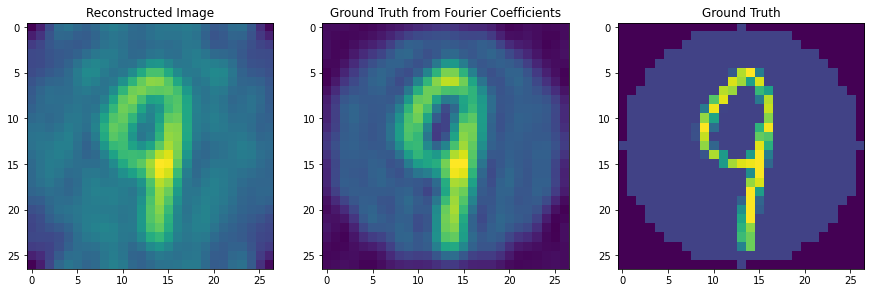

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
rec_img = denormalize(np.roll(np.fft.irfftn(x_dft*mask, s=2*(img_shape,)), 2*(img_shape//2,), (0, 1)), 
                      mean.item(), std.item())
plt.imshow(rec_img)
plt.title('Reconstructed Image');
plt.subplot(1,3,2)
y_target = denormalize(
    np.roll(np.fft.irfftn(y_fc_.reshape(*target_shape)*mask, s=2*(img_shape,)), 2*(img_shape//2,), (0, 1)), 
    mean.item(), std.item())
plt.imshow(y_target)
plt.title('Ground Truth from Fourier Coefficients');
plt.subplot(1,3,3)
plt.imshow(denormalize(y_real[i], mean, std))
plt.title('Ground Truth');

In [21]:
print('PSNR Binned GT: {:2.3f}'.format(
    PSNR(denormalize(y_real[i], mean, std), 
         denormalize(torch.from_numpy(y_target), mean, std), torch.tensor(255., dtype=torch.float32)).item()))

PSNR Binned GT: 19.704


In [22]:
print('MSE Input    : {:4.3f}'.format(np.mean((y_real[i].numpy() - rec_img)**2)))
print('MSE Binned GT: {:4.3f}'.format(np.mean((y_real[i].numpy() - y_target)**2)))

MSE Input    : 3840.675
MSE Binned GT: 3817.937


# Training-Step and Real-Loss

In [23]:
for x_fc, y_fc, y_real, (mag_min, mag_max) in train_dl:
    break

In [24]:
shells = (det_len//2+1) / bin_factor
num_sino_fcs = np.clip(num_angles * int(shells + 1), 1, x_fc.shape[1])
num_target_fcs = np.sum(order <= shells)

In [25]:
t_src_flatten_order = torch.from_numpy(src_flatten_order)
t_dst_flatten_order = torch.from_numpy(dst_flatten_order)

In [26]:
x_fc_ = x_fc[:, t_src_flatten_order][:, :num_sino_fcs]

In [27]:
y_fc_ = y_fc[:, t_dst_flatten_order][:, :num_target_fcs]

In [28]:
pred_fc = y_fc_.clone()

In [29]:
dft_pred = convert_to_dft(pred_fc, mag_min, mag_max, t_dst_flatten_order, img_shape=img_shape)
dft_target = convert_to_dft(y_fc_, mag_min, mag_max, t_dst_flatten_order, img_shape=img_shape)

In [30]:
mask = psfft(bin_factor, pixel_res=img_shape)

In [31]:
dft_pred *= mask
dft_target *= mask

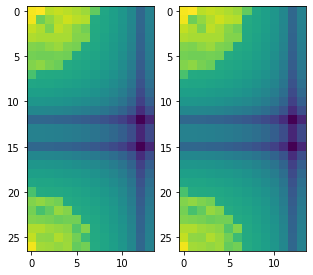

In [32]:
plt.figure(figsize=(5,10))
plt.subplot(1,2,1)
plt.imshow(torch.log(dft_pred[0].abs()))
plt.subplot(1,2,2)
plt.imshow(torch.log(dft_target[0].abs()))

In [33]:
y_hat = torch.roll(torch.fft.irfftn(dft_pred, dim=[1, 2], s=(img_shape, img_shape)),
                   2*(img_shape // 2, ), (1, 2))
y_target = torch.roll(torch.fft.irfftn(dft_target, dim=[1,2], s=(img_shape, img_shape)),
                     2*(img_shape // 2, ), (1, 2))

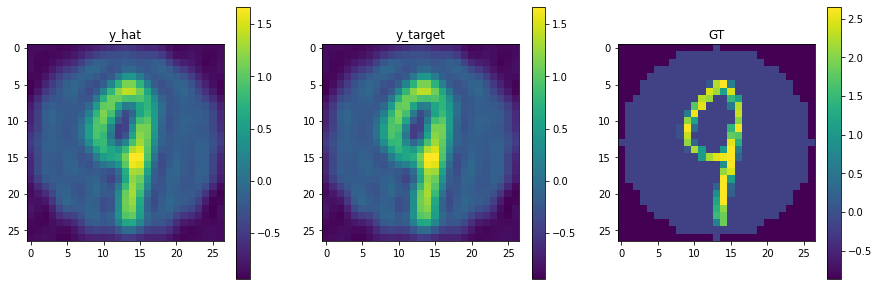

In [34]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(y_hat[0])
plt.colorbar()
plt.title('y_hat');
plt.subplot(1,3,2)
plt.imshow(y_target[0])
plt.colorbar()
plt.title('y_target');
plt.subplot(1,3,3)
plt.imshow(y_real[0])
plt.colorbar()
plt.title('GT');